In [1]:
# This file contains machine learning explainability problems, specifically partial plots, to 
# refer back to when writing new code
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
# Data manipulation code below here
data = pd.read_csv('data/train.csv', nrows=50000)

# Remove data with extreme outlier coordinates or negative fares
data = data.query('pickup_latitude > 40.7 and pickup_latitude < 40.8 and ' +
                  'dropoff_latitude > 40.7 and dropoff_latitude < 40.8 and ' +
                  'pickup_longitude > -74 and pickup_longitude < -73.9 and ' +
                  'dropoff_longitude > -74 and dropoff_longitude < -73.9 and ' +
                  'fare_amount > 0'
                  )

y = data.fare_amount

base_features = ['pickup_longitude',
                 'pickup_latitude',
                 'dropoff_longitude',
                 'dropoff_latitude']

X = data[base_features]


train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
first_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(train_X, train_y)
print("Data sample:")
data.head()

Data sample:


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1


In [3]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,31289.000000,31289.000000,31289.000000,31289.000000,31289.000000,31289.000000
mean,8.483093,-73.976860,40.756917,-73.975342,40.757473,1.656141
std,4.628164,0.014635,0.018170,0.015917,0.018661,1.284899
min,0.010000,-73.999999,40.700013,-73.999999,40.700020,0.000000
25%,5.500000,-73.988039,40.744947,-73.987125,40.745922,1.000000
50%,7.500000,-73.979691,40.758027,-73.978547,40.758559,1.000000
75%,10.100000,-73.967823,40.769580,-73.966435,40.770427,2.000000
max,165.000000,-73.900062,40.799952,-73.900062,40.799999,6.000000


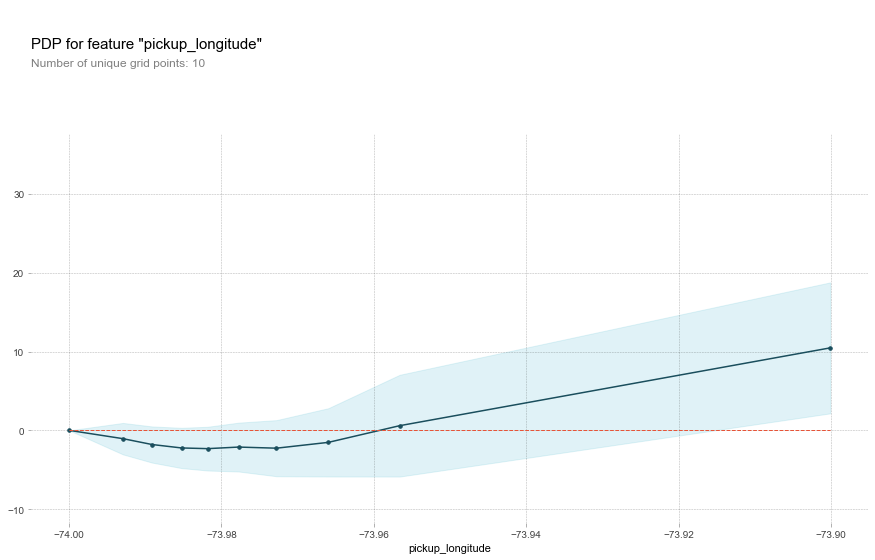

In [5]:
# Here is the code to plot the partial dependence plot for pickup_longitude
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

feat_name = 'pickup_longitude'
pdp_dist = pdp.pdp_isolate(model=first_model, dataset=val_X, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

Why does the partial dependence plot have this U-shape?

Does your explanation suggest what shape to expect in the partial dependence plots for the other features?

Create all other partial plots in a for-loop below.

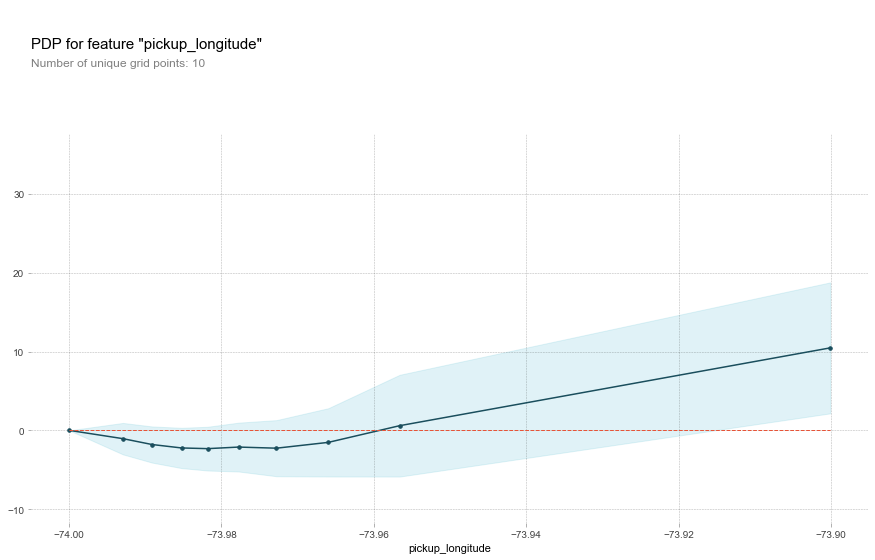

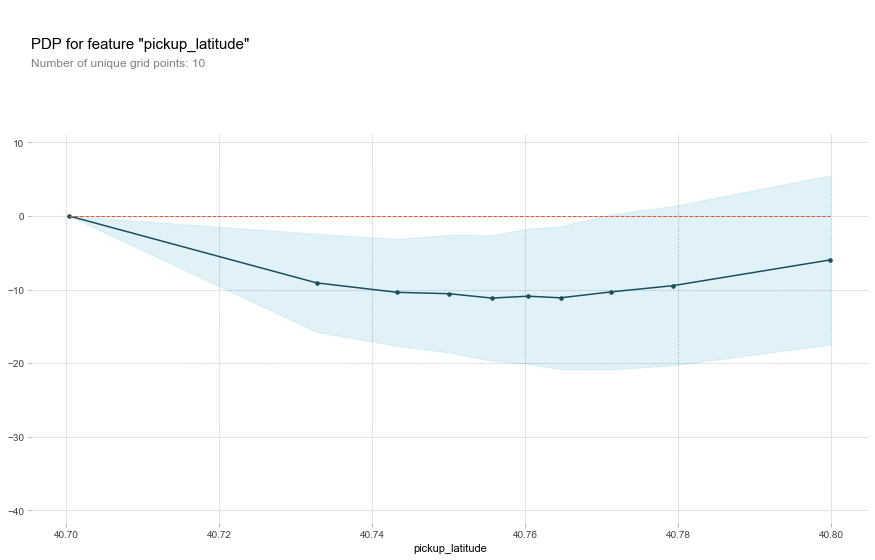

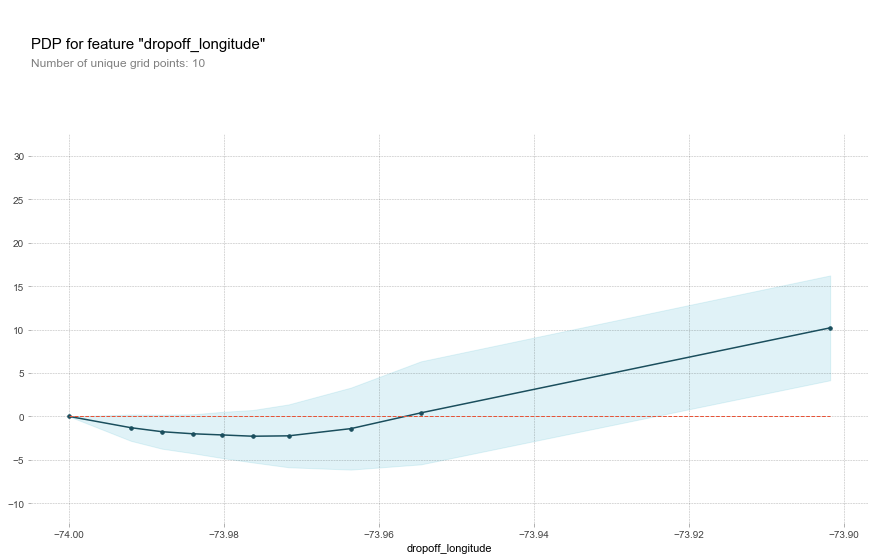

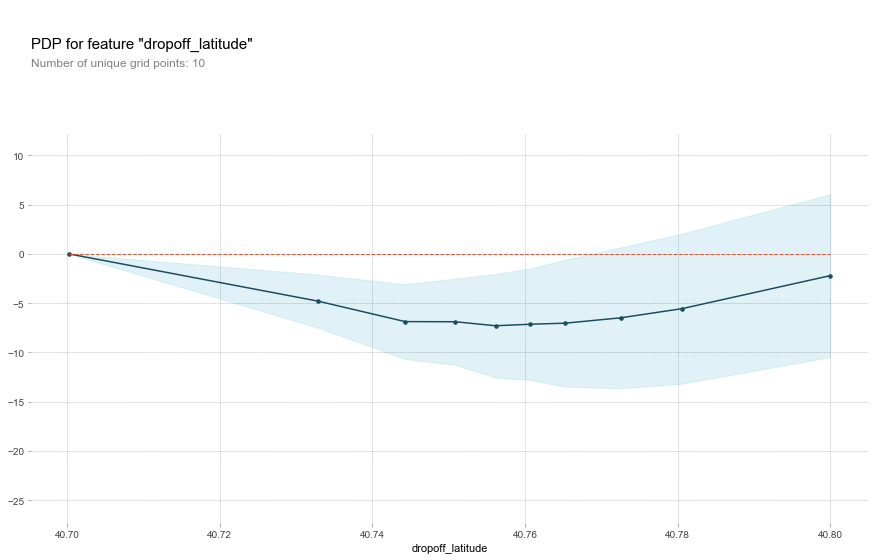

In [6]:
for feat_name in base_features:
    pdp_dist = pdp.pdp_isolate(model=first_model, dataset=val_X, model_features=base_features, feature=feat_name)
    pdp.pdp_plot(pdp_dist, feat_name)
    plt.show()

Do the shapes match your expectations for what shapes they would have? Can you explain the shape now that you've seen them?

We have a sense from the permutation importance results that distance is the most important determinant of taxi fare.

This model didn't include distance measures (like absolute change in latitude or longitude) as features, so coordinate features (like pickup_longitude) capture the effect of distance. Being picked up near the center of the longitude values lowers predicted fares on average, because it means shorter trips (on average).

For the same reason, we see the general U-shape in all our partial dependence plots.

Create a 2D plot for the features `pickup_longitude` and `dropoff_longitude`.  Plot it appropriately?

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

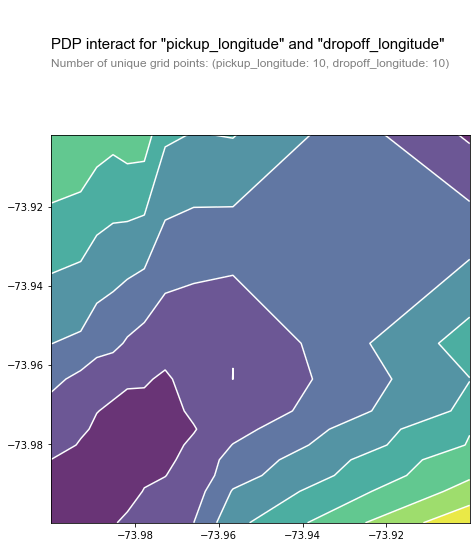

In [7]:
inter = pdp.pdp_interact(model=first_model, dataset=val_X, model_features=base_features, features=['pickup_longitude', 'dropoff_longitude'])
pdp.pdp_interact_plot(pdp_interact_out=inter, feature_names=['pickup_longitude', 'dropoff_longitude'], plot_type='contour')
plt.show()

You should expect the plot to have contours running along a diagonal. We see that to some extent, though there are interesting caveats.

We expect the diagonal contours because these are pairs of values where the pickup and dropoff longitudes are nearby, indicating shorter trips (controlling for other factors).

As you get further from the central diagonal, we should expect prices to increase as the distances between the pickup and dropoff longitudes also increase.

The surprising feature is that prices increase as you go further to the upper-right of this graph, even staying near that 45-degree line.

This could be worth further investigation, though the effect of moving to the upper right of this graph is small compared to moving away from that 45-degree line.

The code you need to create the desired plot is:

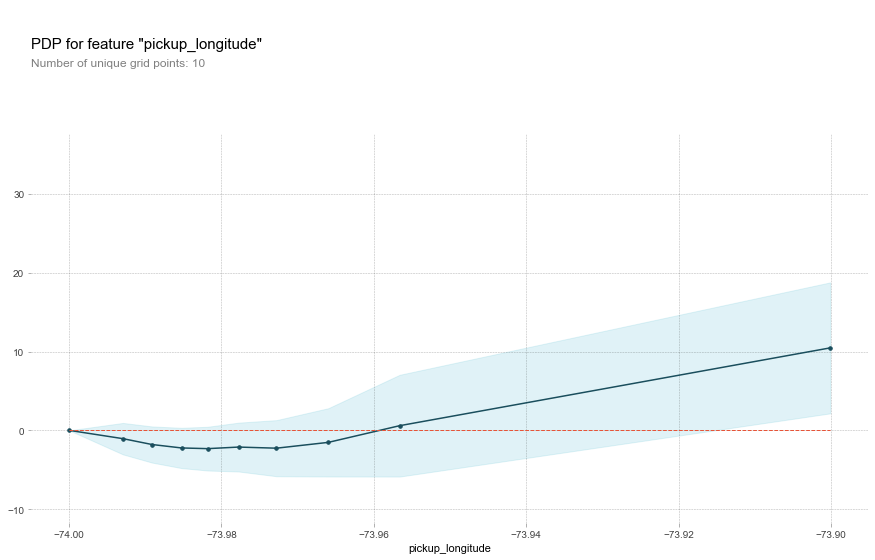

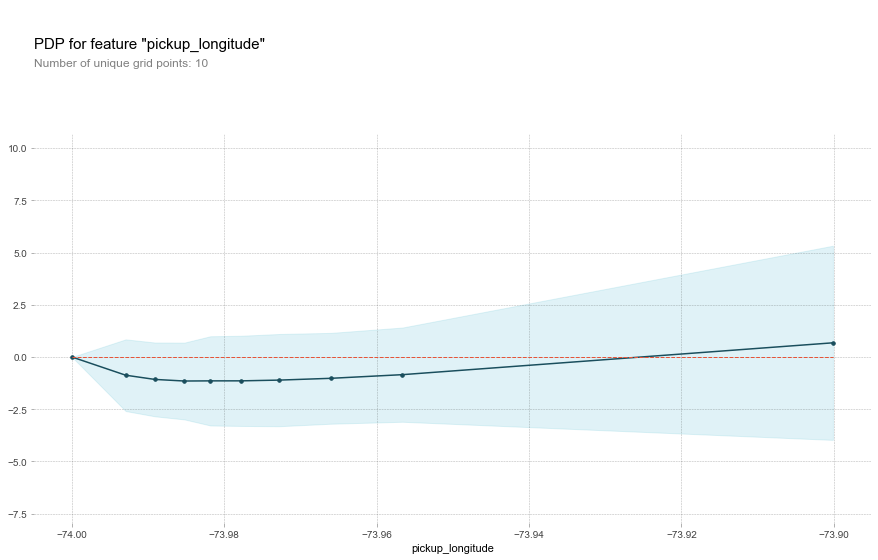

In [8]:
# This is the PDP for pickup_longitude without the absolute difference features. Included here to help compare it to the new PDP you create
feat_name = 'pickup_longitude'
pdp_dist_original = pdp.pdp_isolate(model=first_model, dataset=val_X, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist_original, feat_name)
plt.show()



# create new features
data['abs_lon_change'] = abs(data.dropoff_longitude - data.pickup_longitude)
data['abs_lat_change'] = abs(data.dropoff_latitude - data.pickup_latitude)

features_2  = ['pickup_longitude',
               'pickup_latitude',
               'dropoff_longitude',
               'dropoff_latitude',
               'abs_lat_change',
               'abs_lon_change']

X = data[features_2]
new_train_X, new_val_X, new_train_y, new_val_y = train_test_split(X, y, random_state=1)
second_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(new_train_X, new_train_y)

feat_name = 'pickup_longitude'
pdp_dist = pdp.pdp_isolate(model=second_model, dataset=new_val_X, model_features=features_2, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

1. Creates two features, X1 and X2, having random values in the range [-2, 2].
2. Creates a target variable y, which is always 1.
3. Trains a RandomForestRegressor model to predict y given X1 and X2.
4. Creates a PDP plot for X1 and a scatter plot of X1 vs. y.

Do you have a prediction about what the PDP plot will look like? Run the cell to find out.

Modify the initialization of y so that our PDP plot has a positive slope in the range [-1,1], and a negative slope everywhere else.

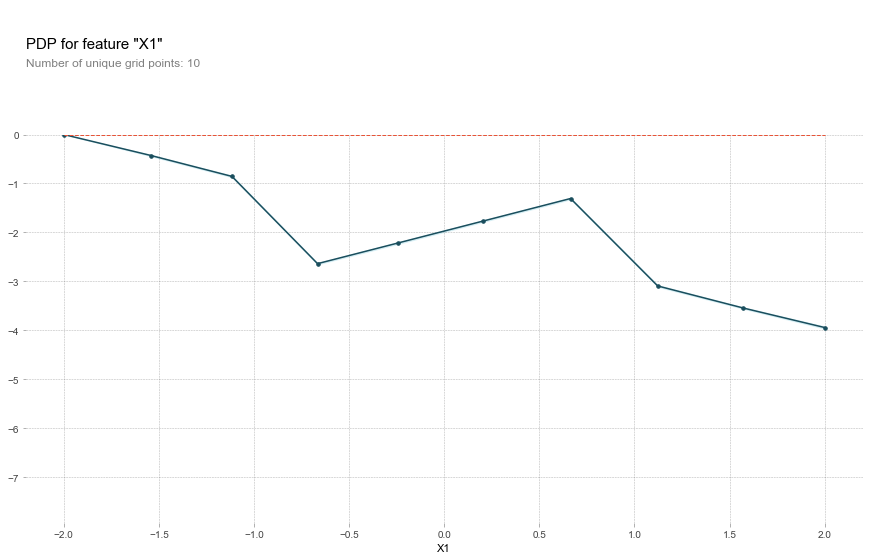

In [9]:
import numpy as np
from numpy.random import rand

n_samples = 20000

# Create array holding predictive feature
X1 = 4 * rand(n_samples) - 2
X2 = 4 * rand(n_samples) - 2
# Create y. you should have X1 and X2 in the expression for y
y = -2 * X1 * (X1<-1) + X1 - 2 * X1 * (X1>1) - X2

# create dataframe because pdp_isolate expects a dataFrame as an argument
my_df = pd.DataFrame({'X1': X1, 'X2': X2, 'y': y})
predictors_df = my_df.drop(['y'], axis=1)

my_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(predictors_df, my_df.y)

pdp_dist = pdp.pdp_isolate(model=my_model, dataset=my_df, model_features=['X1', 'X2'], feature='X1')

# visualize your results
pdp.pdp_plot(pdp_dist, 'X1')
plt.show()

Create a dataset with 2 features and a target, such that the pdp of the first feature is flat, but its permutation importance is high. We will use a RandomForest for the model.

Using TensorFlow backend.


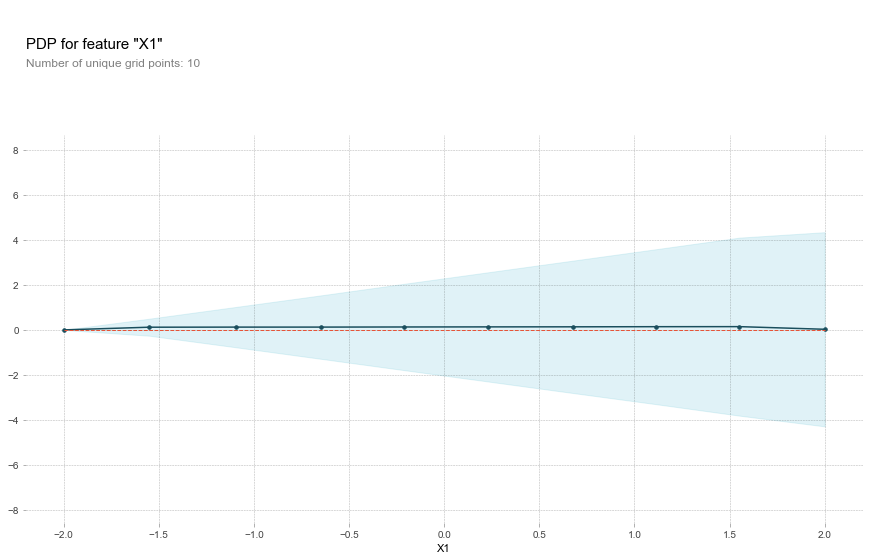

Weight,Feature
1.9982 ± 0.0243,X1
1.9951 ± 0.0345,X2


In [10]:
import eli5
from eli5.sklearn import PermutationImportance

n_samples = 20000

# Create array holding predictive feature
X1 = 4 * rand(n_samples) - 2
X2 = 4 * rand(n_samples) - 2
# Create y. you should have X1 and X2 in the expression for y
y = X1 * X2


# create dataframe because pdp_isolate expects a dataFrame as an argument
my_df = pd.DataFrame({'X1': X1, 'X2': X2, 'y': y})
predictors_df = my_df.drop(['y'], axis=1)

my_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(predictors_df, my_df.y)


pdp_dist = pdp.pdp_isolate(model=my_model, dataset=my_df, model_features=['X1', 'X2'], feature='X1')
pdp.pdp_plot(pdp_dist, 'X1')
plt.show()

perm = PermutationImportance(my_model).fit(predictors_df, my_df.y)

# show the weights for the permutation importance you just calculated
eli5.show_weights(perm, feature_names = ['X1', 'X2'])